In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sympy
from sympy import Symbol,sqrt, symbols, oo, Derivative,diff, Matrix, print_latex, Rational, simplify, O

import matplotlib.pyplot as plt


import tensorflow as tf

import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential


from keras.layers import Dense, LSTM

import random

from IPython.display import HTML

from tqdm import tqdm

In [3]:
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket
from acchamiltoniansandmatrices.Factorization.Factorization import taylor_to_lie, taylor_to_weight_mat, taylorize
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.MachineLearning.DeepLie_mods import LieMapBuilder, LieLayer, printlist
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift4D,
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad4D,
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
    HamSext6D
)
from acchamiltoniansandmatrices.Matrices.SymbMatrices import RsymbQuad4D
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import RnpQuad4D

In [26]:
x, px, y, py, z, pz, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z p_z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

In [5]:
def drift(r,l):
    """
    Drift map 4D
    """
    rep = list(zip([L,x,px,y,py],[l,r[0],r[1],r[2],r[3]]))
    
    H = HamDrift4D(beta0,gamma0,L,x,px,y,py).subs(beta0*gamma0,oo).subs(beta0,1)
    
    xn = x + diff(H,px)
    pxn = px
    yn = y + diff(H,py)
    pyn = py

    return xn.subs(rep), pxn.subs(rep), yn.subs(rep), pyn.subs(rep)

def quadf(r,l,k):
    """
    Quad map 4D
    """
    rep = list(zip([L,k1,x,px,y,py],[l,k,r[0],r[1],r[2],r[3]]))
    zn = RsymbQuad4D(beta0, gamma0,L,k1)*Matrix([[x],[px],[y],[py]])
    return zn[0].subs(rep), zn[1].subs(rep), zn[2].subs(rep), zn[3].subs(rep),

In [6]:
def make_rhs(_ham,_coords,_mom):
    _rhs = []
    for coord, mom in zip(_coords,_mom):
        _rhs.append(PoissonBracket(coord, _ham,coords=_coords,mom=_mom).doit())
        _rhs.append(PoissonBracket(mom, _ham,coords=_coords,mom=_mom).doit())
    
    return _rhs

# Approximations

The first approximations we will make are
$$\frac{1}{\beta_0^2\gamma_0^2} \rightarrow 0 \\
\beta_0 \rightarrow 1,
$$
in that order.

In [7]:
# substitution lists
repbg  = list(zip([beta0*gamma0, beta0],[oo,1]))
repeps = list(zip([x,px,y,py],[eps*x,eps*px,y*eps,py*eps]))

In [8]:
# Drift first order
HamDrift6D(beta0,gamma0,L,x,px,y,py,delta).subs(repbg).subs(repeps).series(eps,0,4).removeO().subs(eps,1).expand().collect(1)

L*delta + L*p_x**2/(2*sqrt(delta**2 + 2*delta + 1)) + L*p_y**2/(2*sqrt(delta**2 + 2*delta + 1)) - L*sqrt(delta**2 + 2*delta + 1)

In [9]:
# Drift second order
HamDrift6D(beta0,gamma0,L,x,px,y,py,delta).subs(repbg).subs(repeps).series(eps,0,6).removeO().subs(eps,1).expand().collect(1)

L*delta + L*p_x**4*sqrt(delta**2 + 2*delta + 1)/(8*(delta**4 + 4*delta**3 + 6*delta**2 + 4*delta + 1)) + L*p_x**2*p_y**2*sqrt(delta**2 + 2*delta + 1)/(4*(delta**4 + 4*delta**3 + 6*delta**2 + 4*delta + 1)) + L*p_x**2/(2*sqrt(delta**2 + 2*delta + 1)) + L*p_y**4*sqrt(delta**2 + 2*delta + 1)/(8*(delta**4 + 4*delta**3 + 6*delta**2 + 4*delta + 1)) + L*p_y**2/(2*sqrt(delta**2 + 2*delta + 1)) - L*sqrt(delta**2 + 2*delta + 1)

In [10]:
# Drift third order
HamDrift6D(beta0,gamma0,L,x,px,y,py,delta).subs(repbg).subs(repeps).series(eps,0,8).removeO().subs(eps,1).expand().collect(1)

L*delta + L*p_x**6*sqrt(delta**2 + 2*delta + 1)/(16*(delta**6 + 6*delta**5 + 15*delta**4 + 20*delta**3 + 15*delta**2 + 6*delta + 1)) + 3*L*p_x**4*p_y**2*sqrt(delta**2 + 2*delta + 1)/(16*(delta**6 + 6*delta**5 + 15*delta**4 + 20*delta**3 + 15*delta**2 + 6*delta + 1)) + L*p_x**4*sqrt(delta**2 + 2*delta + 1)/(8*(delta**4 + 4*delta**3 + 6*delta**2 + 4*delta + 1)) + 3*L*p_x**2*p_y**4*sqrt(delta**2 + 2*delta + 1)/(16*(delta**6 + 6*delta**5 + 15*delta**4 + 20*delta**3 + 15*delta**2 + 6*delta + 1)) + L*p_x**2*p_y**2*sqrt(delta**2 + 2*delta + 1)/(4*(delta**4 + 4*delta**3 + 6*delta**2 + 4*delta + 1)) + L*p_x**2/(2*sqrt(delta**2 + 2*delta + 1)) + L*p_y**6*sqrt(delta**2 + 2*delta + 1)/(16*(delta**6 + 6*delta**5 + 15*delta**4 + 20*delta**3 + 15*delta**2 + 6*delta + 1)) + L*p_y**4*sqrt(delta**2 + 2*delta + 1)/(8*(delta**4 + 4*delta**3 + 6*delta**2 + 4*delta + 1)) + L*p_y**2/(2*sqrt(delta**2 + 2*delta + 1)) - L*sqrt(delta**2 + 2*delta + 1)

In [11]:
HamQuad6DParaxialSecondOrder(beta0,gamma0,L,x,px,y,py,delta,k1).subs(delta,0).collect(k1/2)

L*(k_1*(x**2 - y**2)/2 + p_x**2/2 + p_y**2/2)

In [12]:
H_drift = simplify(HamDrift4D(beta0,gamma0,L,x,px,y,py).subs(repbg).subs(repeps).series(eps,0,6).removeO().subs(eps,1)/L)
H_drift

p_x**4/8 + p_x**2*p_y**2/4 + p_x**2/2 + p_y**4/8 + p_y**2/2 - 1

In [13]:
H_quad = simplify(HamQuad6DParaxialSecondOrder(beta0,gamma0,L,x,px,y,py,delta,k1).subs(delta,0).collect(k1/2)/L)-1
H_quad

k_1*(x**2 - y**2)/2 + p_x**2/2 + p_y**2/2 - 1

In [14]:
sym_x, sym_y, sym_z, sym_px, sym_py, sym_pz, sym_k, sym_l, sym_d = sympy.symbols('x y z p_x p_y delta k_{Q} L D')
J = np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])

In [15]:
i_coord = [sym_x,sym_y]
i_mom = [sym_px,sym_py]
tot_coords = [sym_x,sym_px,sym_y,sym_py]


approx_degree = 3
approx_degree_quad = 2

_epstemp = sympy.symbols('e')
full_drift = - sqrt(1 - _epstemp*(sym_px ** 2 + sym_py ** 2))


H_drift = full_drift.series(_epstemp,n=approx_degree).removeO().subs(_epstemp,1)


H_drift_quad = full_drift.series(_epstemp,n=approx_degree_quad).removeO().subs(_epstemp,1)
H_quad = H_drift_quad + sym_k*(sym_x**2 - sym_y**2)/2

In [16]:
H_drift

p_x**4/8 + p_x**2*p_y**2/4 + p_x**2/2 + p_y**4/8 + p_y**2/2 - 1

In [17]:
H_quad

k_{Q}*(x**2 - y**2)/2 + p_x**2/2 + p_y**2/2 - 1

# FODO: Runge-Kutta integrator vs exact drift

In [14]:
# sympletic
J = np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])

In [67]:
_k1 = 0.5
_k2 = -0.5
delta = 0

_ld = 2.5
_lqf = 0.25
_lqd = 0.5

_r0 = [[10e-7,0,10e-7,0],
       [10e-4,0,10e-4,0],
       [0.1,0,0.1,0],
       [0.25,0,0.25,0],
       [0.5,0,0.5,0],
       [1,0,1,0],
       [2,0,2,0]
      ]

i_coord = [x,y]
i_mom = [px,py]
invector = [x,px,y,py]

In [16]:
from platform import python_version
print(python_version())

3.6.12


In [17]:
def Ivanov_RK(kq1,kq2,l_d,l_qf,l_qd,_state, _order=1):
    exp_order = _order
    integrator_loops = 10

    state = np.array(_state)

    drift_rhs = make_rhs(H_drift,i_coord,i_mom)
    quadf_rhs = make_rhs(H_quad.subs(k1,kq1),i_coord,i_mom)
    quadd_rhs = make_rhs(H_quad.subs(k1,kq2),i_coord,i_mom)


    map_builder_drift = LieMapBuilder(state, drift_rhs, order=exp_order)
    R_drift = map_builder_drift.getInitR()
    R_drift = map_builder_drift.propogate(h=l_d/integrator_loops, N=integrator_loops, verbose=False)

    map_builder_quadf = LieMapBuilder(state, quadf_rhs, order=exp_order)
    R_quadf = map_builder_quadf.getInitR()
    R_quadf = map_builder_quadf.propogate(h=l_qf/integrator_loops, N=integrator_loops, verbose=False)

    map_builder_quadd = LieMapBuilder(state, quadd_rhs, order=exp_order)
    R_quadd = map_builder_quadd.getInitR()
    R_quadd = map_builder_quadd.propogate(h=l_qd/integrator_loops, N=integrator_loops, verbose=False)

    W_drift_RK = map_builder_drift.convert_weights_to_full_nn(R_drift)
    W_quadf_RK = map_builder_quadf.convert_weights_to_full_nn(R_quadf)
    W_quadd_RK = map_builder_quadd.convert_weights_to_full_nn(R_quadd)


    dim = len(state)  # predefined state vector dimension, contains physical parameters of a particle
    order = _order # predefined order of nonlinearity, order of Lie map


    Drift_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_RK, Drift_RK, QuadD_RK, Drift_RK, QuadF_RK]

    # simply construct a neural network (computatuonal graph)
    fodo_RK = Sequential()
    for el in lattice:
        fodo_RK.add(el)

    Drift_RK.set_weights(W_drift_RK)
    QuadF_RK.set_weights(W_quadf_RK)
    QuadD_RK.set_weights(W_quadd_RK)
    
    
    W_drift_RK_corr = [W_drift_RK[0],correct_weigths(W_drift_RK[1]),W_drift_RK[2],W_drift_RK[3]]
    W_quadf_RK_corr = [W_quadf_RK[0],correct_weigths(W_quadf_RK[1]),W_quadf_RK[2],W_quadf_RK[3]]
    W_quadd_RK_corr = [W_quadd_RK[0],correct_weigths(W_quadd_RK[1]),W_quadd_RK[2],W_quadd_RK[3]]
    
    
    printlist(W_drift_RK_corr)
    printlist(W_quadf_RK_corr)
    printlist(W_quadd_RK_corr)
    

    Drift_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_RK_corr, Drift_RK_corr, QuadD_RK_corr, Drift_RK_corr, QuadF_RK_corr]

    # simply construct a neural network (computatuonal graph)
    fodo_RK_corr = Sequential()
    for el in lattice:
        fodo_RK_corr.add(el)

    Drift_RK_corr.set_weights(W_drift_RK_corr)
    QuadF_RK_corr.set_weights(W_quadf_RK_corr)
    QuadD_RK_corr.set_weights(W_quadd_RK_corr)
    
    return fodo_RK, fodo_RK_corr


In [35]:
def LieTrackingt(kq1,kq2,l_d,l_qf,l_qd,tot_coords,_order=2):
    taylor_order = _order
    
    H_quadf = H_quad.subs(k1,kq1)
    H_quadd = H_quad.subs(k1,kq2)
 
    L_drift = LieOperator(-l_d * H_drift,i_coord,i_mom)
    L_quadf = LieOperator(-l_qf * H_quadf,i_coord,i_mom)
    L_quadd = LieOperator(-l_qd * H_quadd,i_coord,i_mom)
    
    taylor_drift = taylorize(L_drift,taylor_order)
    taylor_quadf = taylorize(L_quadf,taylor_order)
    taylor_quadd = taylorize(L_quadd,taylor_order)
    
    print(taylor_drift)
    print(taylor_quadf)
    print(taylor_quadd)
    
    nn_drift = taylor_to_weight_mat(taylor_drift, [x,px,y,py])
    nn_quadf = taylor_to_weight_mat(taylor_quadf, [x,px,y,py])
    nn_quadd = taylor_to_weight_mat(taylor_quadd, [x,px,y,py])

    print(nn_drift)
    print(nn_quadf)
    print(nn_quadd)

    
#     corr_drift = correct_weights(M_taylor_drift[0])
    corr_qf = correct_weigths(nn_quadf[0])
    corr_qd = correct_weigths(nn_quadd[0])
    
    disp = np.array([[0,0,0,0]])


    W_drift_Lie = [disp] + nn_drift
    W_quadf_Lie = [disp] + nn_quadf
    W_quadd_Lie = [disp] + nn_quadd
    
    
    W_drift_Lie_corr = [disp] + nn_drift
    W_quadf_Lie_corr = [disp] + [corr_qf]
    W_quadd_Lie_corr = [disp] + [corr_qd]


    printlist(W_drift_Lie_corr)
    printlist(W_quadf_Lie_corr)
    printlist(W_quadd_Lie_corr)


    dim = len(tot_coords)


    # e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
    Drift_Lie = LieLayer(output_dim = dim, order = len(nn_drift), input_shape = (dim,))
    QuadF_Lie = LieLayer(output_dim = dim, order = len(nn_quadf), input_shape = (dim,))
    QuadD_Lie = LieLayer(output_dim = dim, order = len(nn_quadf), input_shape = (dim,))

    lattice = [QuadF_Lie, Drift_Lie, QuadD_Lie, Drift_Lie, QuadF_Lie]

    # simply construct a neural network (computatuonal graph)
    fodo_Lie = Sequential()
    for el in lattice:
        fodo_Lie.add(el)

    Drift_Lie.set_weights(W_drift_Lie)
    QuadF_Lie.set_weights(W_quadf_Lie)
    QuadD_Lie.set_weights(W_quadd_Lie)
    
    

    Drift_Lie_corr = LieLayer(output_dim = dim, order = len(nn_drift), input_shape = (dim,))
    QuadF_Lie_corr = LieLayer(output_dim = dim, order = len(nn_quadf), input_shape = (dim,))
    QuadD_Lie_corr = LieLayer(output_dim = dim, order = len(nn_quadd), input_shape = (dim,))

    lattice = [QuadF_Lie_corr, Drift_Lie_corr, QuadD_Lie_corr, Drift_Lie_corr, QuadF_Lie_corr]

    # simply construct a neural network (computatuonal graph)
    fodo_Lie_corr = Sequential()
    for el in lattice:
        fodo_Lie_corr.add(el)

    Drift_Lie_corr.set_weights(W_drift_Lie_corr)
    QuadF_Lie_corr.set_weights(W_quadf_Lie_corr)
    QuadD_Lie_corr.set_weights(W_quadd_Lie_corr)
    
    return fodo_Lie, fodo_Lie_corr

def correct_weigths(M):
    m11 = M[0,0]
    m12 = M[0,1]
    m21 = M[1,0]
    m22 = M[1,1]
    
    error = np.linalg.norm(np.dot(M.T,np.dot(J,M)) - J)
    
    
                           
    
    if m11*m22 - m12*m21 != 1:
        print('Symplectic error: ', error)
        if m11 != 0:
            m22 = (1+m12*m21)/m11
        elif m21 != 0:
            m12 = (1-m11*m22)/m21
        elif m12 != 0:
            m21 = (1-m11*m22)/m12
        else:
            m11 = 1/m22
    else:
        print("The upper sub-matrix is symplectic.")
        
    m33 = M[2,2]
    m34 = M[2,3]
    m43 = M[3,2]
    m44 = M[3,3]
    
    if m33*m44 - m34*m43 != 1:
        if m33 != 0:
            m44 = (1+m34*m43)/m33
        elif m43 != 0:
            m34 = (1-m33*m44)/m43
        elif m43 != 0:
            m34 = (1-m33*m44)/m43
        else:
            m33 = 1/m44
    else:
        print("The lower sub-matrix is symplectic.")
    
    return np.array([[m11,m12,0,0],[m21,m22,0,0],[0,0,m33,m34],[0,0,m43,m44]])

def TrackFodo(r0,duration=100):
    X_RK = []
    X_Lie = []
    X_Lie_corr = []
    X_RK_corr = []

    X_Exact = []



    for pos in r0:
        X0 = np.array(pos).reshape((-1, 4))
        X_RK.append(X0)
        X_Lie.append(X0)
        X_Lie_corr.append(X0)
        X_RK_corr.append(X0)

        pos = np.array(pos)
        X_Exact.append(pos)

        for i in tqdm(range(duration)): 
            X_RK.append(fodo_RK.predict(X_RK[-1]))
            X_Lie.append(fodo_Lie.predict(X_Lie[-1]))
            X_Lie_corr.append(fodo_Lie_corr.predict(X_Lie_corr[-1]))
            X_RK_corr.append(fodo_RK_corr.predict(X_RK_corr[-1]))

            r = quadf(pos,_lqf,_k1)
            r = drift(r,_ld)
            r = quadf(r,_lqd,_k2)
            r = drift(r,_ld)
            r = quadf(r,_lqf,_k1)
            
            
            X_Exact.append(r)
            pos = np.copy(r)
            
    X_RK = np.array(X_RK)
    X_Lie = np.array(X_Lie)
    X_Lie_corr = np.array(X_Lie_corr)
    X_RK_corr = np.array(X_RK_corr)
    X_Exact = np.array(X_Exact)
    
    return X_RK, X_Lie, X_Exact, X_Lie_corr, X_RK_corr

In [23]:

def drift(r,l):
    x = r[0]
    px = r[1]
    y = r[2]
    py = r[3]
    
    xn = x + l * px / np.sqrt(1 - px**2 - py**2)
    pxn = px
    yn = y + l * py / np.sqrt(1 - px**2 - py**2)
    pyn = py

    
    return xn, pxn, yn, pyn

def quadf(r,l,k):
    x = r[0]
    px = r[1]
    y = r[2]
    py = r[3]
    
    
    k = np.abs(k)

    
    omega = np.sqrt(k)
    sin = np.sin(omega*l)
    cos = np.cos(omega*l)
    sinh = np.sinh(omega * l)
    cosh = np.cosh(omega * l)
    
    xn = cos * x + sin * px / omega
    pxn = cos * px - sin * omega * x
    yn = cosh * y + sinh * py / omega
    pyn = sinh * omega * y + cosh * py
    
    return xn, pxn, yn, pyn

def quadff(r,l,k):
    x = r[0]
    px = r[1]
    y = r[2]
    py = r[3]
    
    
    
    k = np.abs(k)
    
    omega = np.sqrt(k)
    sin = np.sin(omega*l)
    cos = np.cos(omega*l)
    sinh = np.sinh(omega * l)
    cosh = np.cosh(omega * l)
    
    xn = cosh * x + sinh * px / omega
    pxn = cosh * px + sinh * omega * x
    yn = cos * y + sin * py / omega
    pyn = cos * py - sin * omega * y
    
    return xn, pxn, yn, pyn

def LieTracking(kq1,kq2,l_d,l_qf,l_qd,tot_coords,_order=2):
    print(kq1,kq2,l_d,l_qf,l_qd,tot_coords)
    taylor_order = _order

    H_quadf = H_quad.subs(k1,kq1)
    H_quadd = H_quad.subs(k1,kq2)
    
    print(H_quadf)
    print(H_quadd)

    L_drift = LieOperator(-l_d * H_drift,i_coord,i_mom)
    L_quadf = LieOperator(-l_qf * H_quadf,i_coord,i_mom)
    L_quadd = LieOperator(-l_qd * H_quadd,i_coord,i_mom)


    taylor_drift = taylorize(L_drift,taylor_order)
    taylor_quadf = taylorize(L_quadf,taylor_order)
    taylor_quadd = taylorize(L_quadd,taylor_order)
    
    print(taylor_drift)
    print(taylor_quadf)
    print(taylor_quadd)
    
    nn_drift = taylor_to_weight_mat(taylor_drift)
    nn_quadf = taylor_to_weight_mat(taylor_quadf)
    nn_quadd = taylor_to_weight_mat(taylor_quadd)

    print(nn_drift)
    print(nn_quadf)
    print(nn_quadd)

    
#     corr_drift = correct_weights(M_taylor_drift[0])
    corr_qf = correct_weigths(nn_quadf[0])
    corr_qd = correct_weigths(nn_quadd[0])
    
    disp = np.array([[0,0,0,0]])


    W_drift_Lie = [disp] + nn_drift
    W_quadf_Lie = [disp] + nn_quadf
    W_quadd_Lie = [disp] + nn_quadd
    
    
    W_drift_Lie_corr = [disp] + nn_drift
    W_quadf_Lie_corr = [disp] + [corr_qf]
    W_quadd_Lie_corr = [disp] + [corr_qd]


    printlist(W_drift_Lie_corr)
    printlist(W_quadf_Lie_corr)
    printlist(W_quadd_Lie_corr)


    dim = len(tot_coords)


    # e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
    Drift_Lie = LieLayer(output_dim = dim, order = len(nn_drift), input_shape = (dim,))
    QuadF_Lie = LieLayer(output_dim = dim, order = len(nn_quadf), input_shape = (dim,))
    QuadD_Lie = LieLayer(output_dim = dim, order = len(nn_quadd), input_shape = (dim,))

    lattice = [QuadF_Lie, Drift_Lie, QuadD_Lie, Drift_Lie, QuadF_Lie]

    # simply construct a neural network (computatuonal graph)
    fodo_Lie = Sequential()
    for el in lattice:
        fodo_Lie.add(el)

    Drift_Lie.set_weights(W_drift_Lie)
    QuadF_Lie.set_weights(W_quadf_Lie)
    QuadD_Lie.set_weights(W_quadd_Lie)
    
    

    Drift_Lie_corr = LieLayer(output_dim = dim, order = len(nn_drift), input_shape = (dim,))
    QuadF_Lie_corr = LieLayer(output_dim = dim, order = len(nn_quadf), input_shape = (dim,))
    QuadD_Lie_corr = LieLayer(output_dim = dim, order = len(nn_quadd), input_shape = (dim,))

    lattice = [QuadF_Lie_corr, Drift_Lie_corr, QuadD_Lie_corr, Drift_Lie_corr, QuadF_Lie_corr]

    # simply construct a neural network (computatuonal graph)
    fodo_Lie_corr = Sequential()
    for el in lattice:
        fodo_Lie_corr.add(el)

    Drift_Lie_corr.set_weights(W_drift_Lie_corr)
    QuadF_Lie_corr.set_weights(W_quadf_Lie_corr)
    QuadD_Lie_corr.set_weights(W_quadd_Lie_corr)
    
    return fodo_Lie, fodo_Lie_corr


In [19]:
fodo_RK, fodo_RK_corr = Ivanov_RK(_k1,_k2,_ld,_lqf,_lqd,invector,_order=3)

[x p_x y p_y]
[p_x**3/2 + p_x*p_y**2/2 + p_x, 0, p_x**2*p_y/2 + p_y**3/2 + p_y, 0]
[x p_x y p_y]
[p_x, -0.5*x, p_y, 0.5*y]
[x p_x y p_y]
[p_x, 0.5*x, p_y, -0.5*y]
The upper sub-matrix is symplectic.
The lower sub-matrix is symplectic.
Symplectic error:  0.0010416666826491077
Symplectic error:  0.004166667689569775
[[0. 0. 0. 0.]]
[[1.  0.  0.  0. ]
 [2.5 1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  2.5 1. ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0. 

In [36]:
fodo_Lie, fodo_Lie_corr = LieTrackingt(_k1,_k2,_ld,_lqf,_lqd,invector,_order=4)

[1.25*p_x**3 + 1.25*p_x*p_y**2 + 2.5*p_x + x, p_x, 1.25*p_x**2*p_y + 1.25*p_y**3 + 2.5*p_y + y, p_y]
[0.248697916666667*p_x + 0.984415690104167*x, 0.984415690104167*p_x - 0.124348958333333*x, 0.251302083333333*p_y + 1.01566569010417*y, 1.01566569010417*p_y + 0.125651041666667*y]
[0.510416666666667*p_x + 1.06315104166667*x, 1.06315104166667*p_x + 0.255208333333333*x, 0.489583333333333*p_y + 0.938151041666667*y, 0.938151041666667*p_y - 0.244791666666667*y]
2020-12-15 17:11:18,448 - root -INFO - Extracting weight matrices from Taylor vector.
2020-12-15 17:11:18,497 - root -INFO - Extracting weight matrices from Taylor vector.
2020-12-15 17:11:18,503 - root -INFO - Extracting weight matrices from Taylor vector.
[array([[1. , 0. , 0. , 0. ],
       [2.5, 1. , 0. , 0. ],
       [0. , 0. , 1. , 0. ],
       [0. , 0. , 2.5, 1. ]]), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0.

In [ ]:
X_RK, X_Lie, X_Exact, X_Lie_corr, X_RK_corr = TrackFodo(_r0,1000)

  1%|▏         | 13/1000 [00:01<02:20,  7.01it/s]

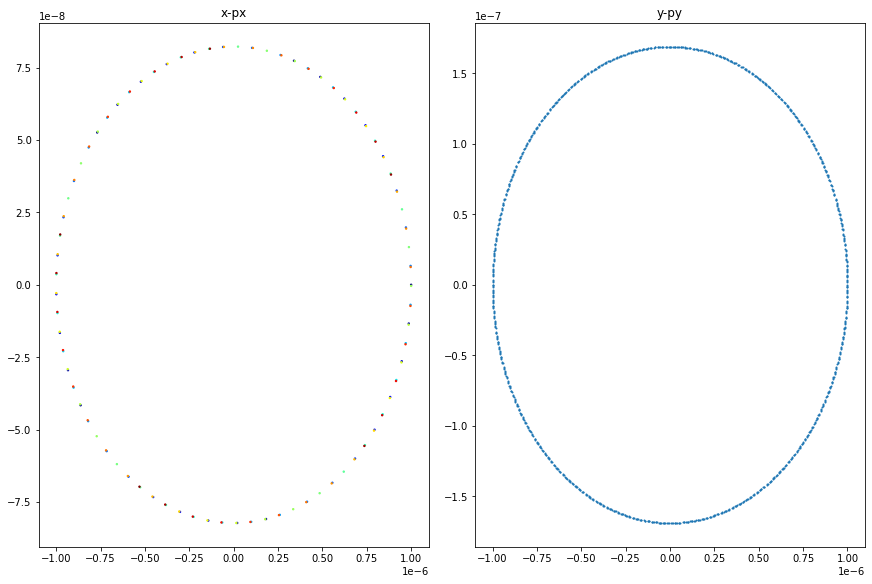

In [66]:
# subplot grid
fig = plt.figure(constrained_layout=True, figsize = (12,8))
gs  = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])


ax1.set_title('x-px')
ax2.set_title('y-py')

# ax1.plot(X_RK[:, 0, 0], X_RK[:, 0, 1], '.', markersize = 2,label='RK')
# ax2.plot(X_RK[:, 0, 2], X_RK[:, 0, 3], '.', markersize = 2,label='RK')

# ax1.plot(X_Lie[:, 0, 0], X_Lie[:, 0, 1], '.', markersize = 2,label='Lie')
# ax2.plot(X_Lie[:, 0, 2], X_Lie[:, 0, 3], '.', markersize = 2,label='Lie')

# ax1.plot(X_Exact[:, 0], X_Exact[:, 1], '.', markersize = 2,label='Exact')
# ax2.plot(X_Exact[:, 2], X_Exact[:, 3], '.', markersize = 2,label='Exact')

ax1.scatter(X_Lie_corr[::7, 0, 0], X_Lie_corr[::7, 0, 1], s=2,label='Lie_corr',c=np.arange(len(X_RK_corr[::7, 0])),cmap="jet")
ax2.plot(X_Lie_corr[:, 0, 2], X_Lie_corr[:, 0, 3], '.', markersize = 2,label='Lie_corr')

# ax1.scatter(X_RK_corr[::7, 0, 0], X_RK_corr[::7, 0, 1],s=1,label='RK_corr', c=np.arange(len(X_RK_corr[::7, 0])),cmap="jet" )
# ax2.plot(X_RK_corr[:, 0, 2], X_RK_corr[:, 0, 3], '.', markersize = 2,label='RK_corr')


In [61]:
X_RK_corr[0::7,0,0]

array([ 1.00000000e-06,  3.46804399e-07, -7.59768682e-07, ...,
       -2.67002845e+00, -8.92015815e-01,  1.35274911e+00])

In [45]:
quadf([1,0.2,3,0.4],6,-1.2)

(422.934971859827, 463.300797006099, 2.97940762400148, -0.554757831896224)

In [32]:
RsymbQuad4D(beta0, gamma0,L,k1)*Matrix([[x],[px],[y],[py]])

Matrix([
[  x*cos(L*sqrt(k_1)) + p_x*sin(L*sqrt(k_1))/sqrt(k_1)],
[ -sqrt(k_1)*x*sin(L*sqrt(k_1)) + p_x*cos(L*sqrt(k_1))],
[y*cosh(L*sqrt(k_1)) + p_y*sinh(L*sqrt(k_1))/sqrt(k_1)],
[sqrt(k_1)*y*sinh(L*sqrt(k_1)) + p_y*cosh(L*sqrt(k_1))]])

In [25]:
H = HamQuad6DParaxialSecondOrder(beta0,gamma0,L,x,px,y,py,delta,k1).subs(beta0*gamma0,oo).subs(beta0,1)
H

L*(k_1*x**2/2 - k_1*y**2/2 + p_x**2/2 + p_y**2/2)

In [24]:
diff(H,px)

L*p_x/sqrt(-p_x**2 - p_y**2 + 1)

In [17]:
rep = list(zip([L,x,px,y,py],[4,0,1,2,3]))
diff(H,px).subs(rep)

-4*I/3